# Installation

To get start is important to install the Spark API for Python also called PySpark and wget in order to download and unzip the file.

In [1]:
!pip install pyspark
!apt-get install wget

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=1fc3110ef142a56d7f0a36208f53ef3c2076573ab8e99c1940a3a64be9a44004
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
wget is already the newest version (1.21.2-2ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


# Downloading the dataset

Here the dataset is organized into dataset folder which contains 3 different data file:
-  `poker-hand-training-true.data`:train data
- `poker-hand-testing.data` : test data
- `poker-hand.names` : README file that explain the data

In [2]:
# Download the zip file:
!wget https://archive.ics.uci.edu/static/public/158/poker+hand.zip

# Unzip the file into a specific folder:
!unzip poker+hand.zip -d dataset

--2023-07-23 16:30:08--  https://archive.ics.uci.edu/static/public/158/poker+hand.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘poker+hand.zip’

poker+hand.zip          [  <=>               ]   5.79M  14.4MB/s    in 0.4s    

2023-07-23 16:30:09 (14.4 MB/s) - ‘poker+hand.zip’ saved [6072758]

Archive:  poker+hand.zip
  inflating: dataset/poker-hand-testing.data  
  inflating: dataset/poker-hand-training-true.data  
  inflating: dataset/poker-hand.names  


# Import

All the library used in the project are written in this section, as we can see the major comes from `pyspark.sql` and `pyspark.ml`

In [3]:
from zipfile import ZipFile

import matplotlib.pyplot as plt


import pyspark as spark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, StringType , DoubleType
from pyspark.sql.functions import col, explode, array, lit

from pyspark.sql.functions import corr
from pyspark.sql.functions import udf
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import RFormula
from pyspark.ml.feature import VectorAssembler


# models
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.classification import GBTClassifier


# evaluators
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import RegressionEvaluator

# Parameters
active_weights = False
expand_dataset = False
reduce_dataset = True
vectorization_type = True # True -> RFormula
                           # False -> Vector Assembler

# Defining the spark object

Apache Spark is an open-source, distributed computing system that provides a unified analytics engine for processing large-scale data sets. It is designed to handle a wide range of data processing tasks, from batch processing to real-time streaming and machine learning.
The main characteristics of the Spark library:

1. **Distributed Computing**: Spark is built to distribute data and computations across a cluster of machines, enabling parallel processing.

2. **Resilient Distributed Datasets (RDDs)**: Spark introduced the concept of RDDs, which are immutable distributed collections of objects. RDDs allow for in-memory data processing and provide fault tolerance through lineage, which allows lost partitions to be recomputed.

3. **Spark Core**: At the core of Spark is the Spark Core library, which provides the basic functionality and APIs for distributed computing.

4. Libraries and APIs: Spark provides a rich ecosystem of libraries and APIs that extend its capabilities for various use cases.

5. **Programming Language Support**: Spark offers APIs in multiple programming languages, including Scala, Java, Python, and R.

6. **Integration with Hadoop**: Spark can be seamlessly integrated with the Hadoop ecosystem, making use of Hadoop Distributed File System (HDFS) for data storage and Hadoop YARN for resource management.

This code creates a SparkSession with the specified configuration, including running Spark locally on a single machine, setting the application name, customizing the Spark UI port, and obtaining an existing SparkSession or creating a new one.

In [4]:
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

1. ***SparkSession.builder***: The builder is an entry point for creating a SparkSession in PySpark. It allows you to configure various aspects of the session before creating it.

2. ***.master("local")***: it sets the URL of the cluster or the master node. In this case, "local" is specified, which means Spark will run in local mode using all available cores on the machine where the code is executed. Local mode is typically used for development and testing purposes.

3. ***.appName("Colab")***: it sets the name of the Spark application. In this case, it is set to "Colab", but you can change it to any desired name.

4. ***.config('spark.ui.port', '4050')***: is used to set various configuration options for the SparkSession. In this line, it sets the value of the configuration property 'spark.ui.port' to '4050'. This property specifies the port number for the Spark application's user interface. By setting it to '4050', the Spark application UI will be accessible at http://localhost:4050.

5. ***.getOrCreate()***:it creates a new SparkSession or retrieves an existing one if available. This allows multiple parts of your code to share the same SparkSession instance, which is recommended for most use cases.



# The dataset

The Poker Hand dataset is a popular dataset used for classification tasks, particularly in the field of machine learning. It contains information about poker hands represented as a set of 10 cards. Each instance in the dataset represents a five-card poker hand, and the objective is to predict the poker hand's class or category.

1. First Card Rank (Numeric): This feature represents the rank or value of the first card in the hand. It is encoded as an integer from 1 to 13, where 1 represents an Ace, 11 represents a Jack, 12 represents a Queen, and 13 represents a King.

2. First Card Suit (Numeric): This feature represents the suit of the first card in the hand. It is encoded as an integer from 1 to 4, where 1 represents Hearts, 2 represents Spades, 3 represents Diamonds, and 4 represents Clubs.

And so on with the second, third, fourth and fifth card.
The last column is:
3. Class (Numeric): This is the target variable or class label for the poker hand. It represents the poker hand's category and is encoded as an integer from 0 to 9, where each value corresponds to a specific hand category:

  0: "Nothing in hand; not a recognized poker hand ",

  1: "One pair; one pair of equal ranks within five cards",

  2: "Two pairs; two pairs of equal ranks within five cards",

  3: "Three of a kind; three equal ranks within five cards",

  4: "Straight; five cards, sequentially ranked with no gaps",

  5: "Flush; five cards with the same suit",

  6: "Full house; pair + different rank three of a kind",

  7: "Four of a kind; four equal ranks within five cards",

  8: "Straight flush; straight + flush",
  
  9: " Royal flush; {Ace, King, Queen, Jack, Ten} + flush",









In [5]:
# header of the dataset
header =  ["S1", "C1", "S2","C2", "S3", "C3", "S4","C4","S5", "C5"]

In [6]:
# schema used for extracting the information comes from the files in the good way
schema = StructType([
    StructField("S1", IntegerType(), True),
    StructField("C1", IntegerType(), True),
    StructField("S2", IntegerType(), True),
    StructField("C2", IntegerType(), True),
    StructField("S3", IntegerType(), True),
    StructField("C3", IntegerType(), True),
    StructField("S4", IntegerType(), True),
    StructField("C4", IntegerType(), True),
    StructField("S5", IntegerType(), True),
    StructField("C5", IntegerType(), True),
    StructField("CLASS", IntegerType(), True)
])

In [7]:
spark_train = spark.read.csv('./dataset/poker-hand-training-true.data', header=False, schema=schema, inferSchema=True)
spark_test = spark.read.csv('./dataset/poker-hand-testing.data', header=False, schema=schema, inferSchema=True)
 # inferSchema is used to prevent all columns from being of type string , predicts data type

columns = spark_train.columns

In [8]:
spark_train.show()

+---+---+---+---+---+---+---+---+---+---+-----+
| S1| C1| S2| C2| S3| C3| S4| C4| S5| C5|CLASS|
+---+---+---+---+---+---+---+---+---+---+-----+
|  1| 10|  1| 11|  1| 13|  1| 12|  1|  1|    9|
|  2| 11|  2| 13|  2| 10|  2| 12|  2|  1|    9|
|  3| 12|  3| 11|  3| 13|  3| 10|  3|  1|    9|
|  4| 10|  4| 11|  4|  1|  4| 13|  4| 12|    9|
|  4|  1|  4| 13|  4| 12|  4| 11|  4| 10|    9|
|  1|  2|  1|  4|  1|  5|  1|  3|  1|  6|    8|
|  1|  9|  1| 12|  1| 10|  1| 11|  1| 13|    8|
|  2|  1|  2|  2|  2|  3|  2|  4|  2|  5|    8|
|  3|  5|  3|  6|  3|  9|  3|  7|  3|  8|    8|
|  4|  1|  4|  4|  4|  2|  4|  3|  4|  5|    8|
|  1|  1|  2|  1|  3|  9|  1|  5|  2|  3|    1|
|  2|  6|  2|  1|  4| 13|  2|  4|  4|  9|    0|
|  1| 10|  4|  6|  1|  2|  1|  1|  3|  8|    0|
|  2| 13|  2|  1|  4|  4|  1|  5|  2| 11|    0|
|  3|  8|  4| 12|  3|  9|  4|  2|  3|  2|    1|
|  1|  3|  4|  7|  1|  5|  2|  4|  4| 13|    0|
|  1|  4|  1|  1|  1|  3|  3|  5|  3|  2|    4|
|  3|  8|  3| 12|  2|  7|  2|  6|  1|  2

In [9]:
spark_train.schema

StructType([StructField('S1', IntegerType(), True), StructField('C1', IntegerType(), True), StructField('S2', IntegerType(), True), StructField('C2', IntegerType(), True), StructField('S3', IntegerType(), True), StructField('C3', IntegerType(), True), StructField('S4', IntegerType(), True), StructField('C4', IntegerType(), True), StructField('S5', IntegerType(), True), StructField('C5', IntegerType(), True), StructField('CLASS', IntegerType(), True)])

In [10]:
spark_test.show()

+---+---+---+---+---+---+---+---+---+---+-----+
| S1| C1| S2| C2| S3| C3| S4| C4| S5| C5|CLASS|
+---+---+---+---+---+---+---+---+---+---+-----+
|  1|  1|  1| 13|  2|  4|  2|  3|  1| 12|    0|
|  3| 12|  3|  2|  3| 11|  4|  5|  2|  5|    1|
|  1|  9|  4|  6|  1|  4|  3|  2|  3|  9|    1|
|  1|  4|  3| 13|  2| 13|  2|  1|  3|  6|    1|
|  3| 10|  2|  7|  1|  2|  2| 11|  4|  9|    0|
|  1|  3|  4|  5|  3|  4|  1| 12|  4|  6|    0|
|  2|  6|  4| 11|  2|  3|  4|  9|  1|  7|    0|
|  3|  2|  4|  9|  3|  7|  4|  3|  4|  5|    0|
|  4|  4|  3| 13|  1|  8|  3|  9|  3| 10|    0|
|  1|  9|  3|  8|  4|  4|  1|  7|  3|  5|    0|
|  4|  7|  3| 12|  1| 13|  1|  9|  2|  6|    0|
|  2| 12|  1|  3|  2| 11|  2|  7|  4|  8|    0|
|  4|  2|  2|  9|  2|  7|  1|  5|  3| 11|    0|
|  1| 13|  2|  6|  1|  6|  2| 11|  3|  5|    1|
|  3|  8|  2|  7|  1|  9|  3|  6|  2|  3|    0|
|  2| 10|  1| 11|  1|  9|  3|  1|  1| 13|    0|
|  4|  2|  4| 12|  2| 12|  2|  7|  3| 10|    1|
|  4|  5|  2|  2|  4|  9|  1|  5|  4|  1

In [11]:
print("Train set")
num_rows = spark_train.count()
print("Number of rows: ", num_rows)

Train set
Number of rows:  25010


In [12]:
print("Test set")
num_rows = spark_test.count()
print("Number of rows: ", num_rows)

Test set
Number of rows:  1000000


# Analysis of the data

The goal of this section is to extract some information from the dataset in order to better improve the machine learning models.
The most important thing that must be checked are the distribution of the instances along the CLASS column (our label column).
As it is evidence in the following code lines the dataset is unbulanced due to the presence of more instances for label 0 and 1  against the smaller amount of instances for the other labels.

In [13]:
dis = spark_train.groupBy("CLASS").count().orderBy("CLASS")
print(dis.show())
print()
all = spark_train.count()
cc = 0
classes = []
counts = []
percentages = []

for c in dis.select("count").collect():
  p = round(c[0]*100 / all,4)
  print(f"{cc}:",p, "%")
  classes.append(cc)
  counts.append(c[0])
  percentages.append(p)
  cc+=1



+-----+-----+
|CLASS|count|
+-----+-----+
|    0|12493|
|    1|10599|
|    2| 1206|
|    3|  513|
|    4|   93|
|    5|   54|
|    6|   36|
|    7|    6|
|    8|    5|
|    9|    5|
+-----+-----+

None

0: 49.952 %
1: 42.379 %
2: 4.8221 %
3: 2.0512 %
4: 0.3719 %
5: 0.2159 %
6: 0.1439 %
7: 0.024 %
8: 0.02 %
9: 0.02 %


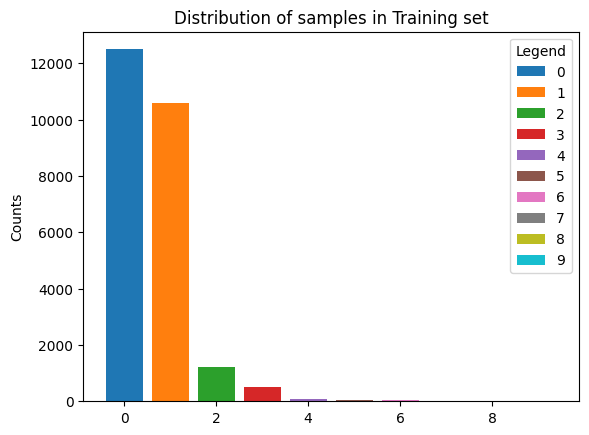

In [14]:
fig, ax = plt.subplots()


bar_labels = ['0', '1','2', '3','4', '5','6', '7','8', '9']
bar_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

ax.bar(classes, counts, label=bar_labels, color=bar_colors)

ax.set_ylabel('Counts')
ax.set_title('Distribution of samples in Training set')
ax.legend(title='Legend')

plt.show()


In [15]:
dis = spark_test.groupBy("CLASS").count().orderBy("CLASS")
print(dis.show())
print("")
all = spark_test.count()
cc = 0.0
weights = {}
classes = []
counts = []
percentages = []
for c in dis.select("count").collect():
  p = round(c[0]*100 / all,4)
  print(f"{cc}:",p, "%")
  weights[cc] = c[0]*100 / all
  classes.append(cc)
  counts.append(c[0])
  percentages.append(p)
  cc+=1


+-----+------+
|CLASS| count|
+-----+------+
|    0|501209|
|    1|422498|
|    2| 47622|
|    3| 21121|
|    4|  3885|
|    5|  1996|
|    6|  1424|
|    7|   230|
|    8|    12|
|    9|     3|
+-----+------+

None

0.0: 50.1209 %
1.0: 42.2498 %
2.0: 4.7622 %
3.0: 2.1121 %
4.0: 0.3885 %
5.0: 0.1996 %
6.0: 0.1424 %
7.0: 0.023 %
8.0: 0.0012 %
9.0: 0.0003 %


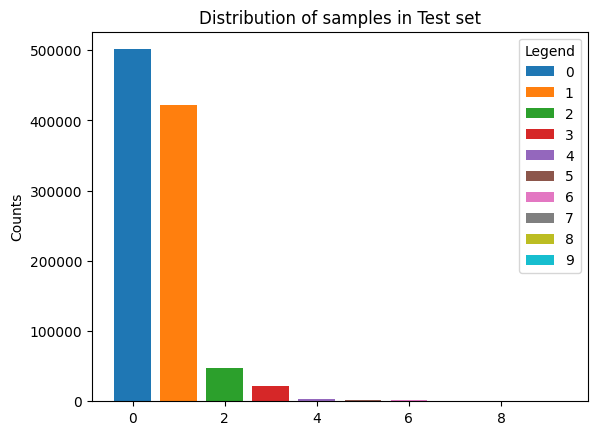

In [16]:
fig, ax = plt.subplots()


bar_labels = ['0', '1','2', '3','4', '5','6', '7','8', '9']
bar_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

ax.bar(classes, counts, label=bar_labels, color=bar_colors)

ax.set_ylabel('Counts')
ax.set_title('Distribution of samples in Test set')
ax.legend(title='Legend')

plt.show()

As it is shown in the above code the distribution of the istances along the classes is not balanced in both training set and test set.

Starting from this information the idea is to save into an array called `weights` the percentage that describes the distribution of instances along classes, it will be use for considering weights in the model definition step.

#### Add new weights

In [17]:
from pyspark.sql.functions import col, lit, when

def new_weights(dataset):
  c = 10
  count_total = dataset.count()
  count_i = []
  weight = []
  for i in dataset.groupBy('CLASS').count().collect():
    z = i[1]
    count_i.append(z)
    weight.append(count_total / (c * z))

  print("Count total:")
  print(count_total)
  print("Count i:")
  print(count_i)
  print("Weights:")
  print(weight)


  dataset = dataset.withColumn("weight", when(col("CLASS") ==0 , weight[0])
                                        .when(col("CLASS") ==1 , weight[1])
                                        .when(col("CLASS") ==2 , weight[2])
                                        .when(col("CLASS") ==3 , weight[3])
                                        .when(col("CLASS") ==4 , weight[4])
                                        .when(col("CLASS") ==5 , weight[5])
                                        .when(col("CLASS") ==6 , weight[6])
                                        .when(col("CLASS") ==7 , weight[7])
                                        .when(col("CLASS") ==8 , weight[8])
                                        .otherwise(weight[9]))

  dataset.select(dataset['*']).where(col('CLASS')==0).show(3)
  dataset.select(dataset['*']).where(col('CLASS')==1).show(3)
  dataset.select(dataset['*']).where(col('CLASS')==2).show(3)
  dataset.select(dataset['*']).where(col('CLASS')==3).show(3)
  dataset.select(dataset['*']).where(col('CLASS')==4).show(3)
  dataset.select(dataset['*']).where(col('CLASS')==5).show(3)
  dataset.select(dataset['*']).where(col('CLASS')==6).show(3)
  dataset.select(dataset['*']).where(col('CLASS')==7).show(3)
  dataset.select(dataset['*']).where(col('CLASS')==8).show(3)
  dataset.select(dataset['*']).where(col('CLASS')==9).show(3)

  return dataset



## Expand the dataset

---
Using  oversampling technique


In [18]:
if expand_dataset:

  data = spark_train.union(spark_test)
  spark_train, spark_test = data.randomSplit([0.7,0.3], seed = 42)
  print("in_train count:",spark_train.count())
  print("in_test count:",spark_test.count())


In [19]:
if active_weights:
  spark_train = new_weights(spark_train)
  spark_test = new_weights(spark_test)


## Reduce the Dataset

+-----+-----+
|CLASS|count|
+-----+-----+
|    0| 6365|
|    1| 5361|
|    2| 1206|
|    3|  513|
|    4|   93|
|    5|   54|
|    6|   36|
|    7|    6|
|    8|    5|
|    9|    5|
+-----+-----+

None

0: 46.6505 %
1: 39.292 %
2: 8.8391 %
3: 3.7599 %
4: 0.6816 %
5: 0.3958 %
6: 0.2639 %
7: 0.044 %
8: 0.0366 %
9: 0.0366 %


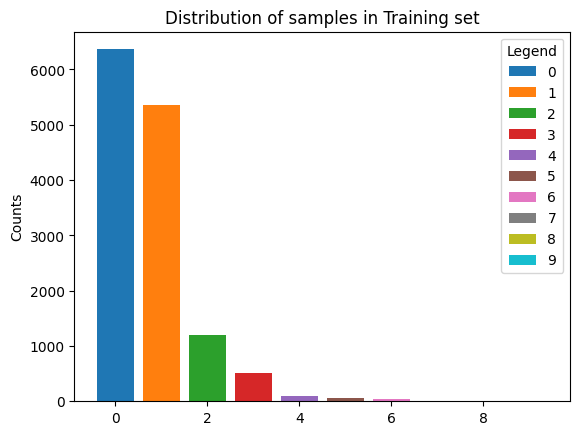

In [20]:
if reduce_dataset:
  spark_train = spark_train.filter(spark_train["CLASS"] == 0).sample(0.5, seed = 42).union(spark_train.filter(spark_train["CLASS"] == 1).sample(0.5, seed = 42)).union(spark_train.filter(spark_train["CLASS"] > 1))

  dis = spark_train.groupBy("CLASS").count().orderBy("CLASS")
  print(dis.show())
  print()
  all = spark_train.count()
  cc = 0
  classes = []
  counts = []
  percentages = []

  for c in dis.select("count").collect():
    p = round(c[0]*100 / all,4)
    print(f"{cc}:",p, "%")
    classes.append(cc)
    counts.append(c[0])
    percentages.append(p)
    cc+=1

  fig, ax = plt.subplots()


  bar_labels = ['0', '1','2', '3','4', '5','6', '7','8', '9']
  bar_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

  ax.bar(classes, counts, label=bar_labels, color=bar_colors)

  ax.set_ylabel('Counts')
  ax.set_title('Distribution of samples in Training set')
  ax.legend(title='Legend')

  plt.show()



# Model implementation

## RFormula

RFormula simplifies the process of preparing data for training machine learning models in PySpark.
It is a class provided by the  `pyspark.ml.feature` module that allows you to specify a formula-style string to define a feature transformation pipeline.
The RFormula class is commonly used in machine learning workflows to specify the relationship between features and the target variable.
In our specific case i used all the features related to the target column `CLASS`.


In [21]:
formulas = ['CLASS ~ . - weight','']

In [22]:
def RFormula_def(formula, in_data):
  rf = RFormula(formula=formula)

  pre_model_data = rf.fit(in_data).transform(in_data)

  print("Pre model data:")
  print(pre_model_data.show())
  print()
  print("Pre model schema:")
  print(pre_model_data.printSchema())

  print()
  print("First row:")

  first_row = pre_model_data.first()
  columns = pre_model_data.columns

  for column in columns:
      value = first_row[column]
      print(f"{column}: {value}")

  # Select the features and label columns
  if active_weights:
    data = pre_model_data.select("features", "label","weight")
  else:
    data = pre_model_data.select("features", "label")
  print("=====================")
  return data

In [23]:
if vectorization_type:
  in_train = RFormula_def(formulas[0],spark_train)
  in_test = RFormula_def(formulas[0],spark_test)

Pre model data:
+---+---+---+---+---+---+---+---+---+---+-----+--------------------+-----+
| S1| C1| S2| C2| S3| C3| S4| C4| S5| C5|CLASS|            features|label|
+---+---+---+---+---+---+---+---+---+---+-----+--------------------+-----+
|  1|  3|  4|  7|  1|  5|  2|  4|  4| 13|    0|[1.0,3.0,4.0,7.0,...|  0.0|
|  3|  7|  3|  9|  2| 12|  2|  5|  4|  4|    0|[3.0,7.0,3.0,9.0,...|  0.0|
|  1| 11|  2|  7|  1|  6|  4|  2|  1|  1|    0|[1.0,11.0,2.0,7.0...|  0.0|
|  3|  2|  1|  6|  2| 11|  4|  3|  2| 10|    0|[3.0,2.0,1.0,6.0,...|  0.0|
|  1|  2|  1| 11|  3|  9|  1|  7|  3|  5|    0|[1.0,2.0,1.0,11.0...|  0.0|
|  1| 10|  4|  1|  4|  4|  4| 12|  1|  9|    0|[1.0,10.0,4.0,1.0...|  0.0|
|  1| 10|  3|  7|  1|  3|  3|  6|  3|  8|    0|[1.0,10.0,3.0,7.0...|  0.0|
|  1|  8|  1| 12|  2|  9|  2|  6|  3|  2|    0|[1.0,8.0,1.0,12.0...|  0.0|
|  4|  7|  4| 10|  3|  1|  3|  3|  2|  5|    0|[4.0,7.0,4.0,10.0...|  0.0|
|  1|  5|  3|  7|  1|  3|  1|  6|  2|  8|    0|[1.0,5.0,3.0,7.0,...|  0.0|
|  4|  3|

The output of RFormula process is a dataset containing all the features singularly and the vector called features that collect togheter the poker hand.

After several attempts I noticed that by trying to merge train and test set and then splitting into 0.7 for train and 0.3 for test the results improved

#### Train and Test reshape

In [24]:
reshape = True

In [25]:

if vectorization_type and reshape:
  data = in_train.union(in_test)

In [26]:
if vectorization_type and reshape:
  in_train, in_test = data.randomSplit([0.7,0.3], seed = 42)
  print("in_train count:",in_train.count())
  print("in_test count:",in_test.count())


in_train count: 709176
in_test count: 304468


## Vector Assembler

Alternative to Rformula it is possible to assemble the features into a vector column using  `VectorAssembler`

Union between train and test set

In [27]:
if not vectorization_type and reshape:
  data = spark_train.union(spark_test)
  data.show()

Assembler definition

In [28]:
if not vectorization_type and reshape:
  assembler = VectorAssembler(inputCols = columns[:-1], outputCol = "features")
  data = assembler.transform(data)

if not vectorization_type and not reshape:
  assembler = VectorAssembler(inputCols = columns[:-1], outputCol = "features")
  in_train = assembler.transform(in_train)
  in_test = assembler.transform(in_test)


Split the data into training and testing sets again:

In [29]:
if not vectorization_type and reshape:
  in_train, in_test = data.randomSplit([0.7,0.3], seed = 42)

# Model definition

In [30]:
in_train.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[1.0,1.0,1.0,2.0,...|  0.0|
|[1.0,1.0,1.0,2.0,...|  0.0|
|[1.0,1.0,1.0,3.0,...|  0.0|
|[1.0,1.0,1.0,4.0,...|  0.0|
|[1.0,1.0,1.0,4.0,...|  0.0|
|[1.0,1.0,1.0,4.0,...|  0.0|
|[1.0,1.0,1.0,5.0,...|  0.0|
|[1.0,1.0,1.0,5.0,...|  0.0|
|[1.0,1.0,1.0,6.0,...|  0.0|
|[1.0,1.0,1.0,9.0,...|  0.0|
|[1.0,1.0,1.0,9.0,...|  0.0|
|[1.0,1.0,1.0,10.0...|  0.0|
|[1.0,1.0,1.0,10.0...|  0.0|
|[1.0,1.0,1.0,11.0...|  0.0|
|[1.0,1.0,1.0,13.0...|  0.0|
|[1.0,1.0,2.0,2.0,...|  0.0|
|[1.0,1.0,2.0,2.0,...|  0.0|
|[1.0,1.0,2.0,3.0,...|  0.0|
|[1.0,1.0,2.0,3.0,...|  0.0|
|[1.0,1.0,2.0,5.0,...|  0.0|
+--------------------+-----+
only showing top 20 rows



In [31]:
in_test.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[1.0,1.0,1.0,3.0,...|  0.0|
|[1.0,1.0,1.0,4.0,...|  0.0|
|[1.0,1.0,1.0,4.0,...|  0.0|
|[1.0,1.0,1.0,5.0,...|  0.0|
|[1.0,1.0,1.0,7.0,...|  0.0|
|[1.0,1.0,1.0,8.0,...|  0.0|
|[1.0,1.0,1.0,8.0,...|  0.0|
|[1.0,1.0,1.0,10.0...|  0.0|
|[1.0,1.0,1.0,11.0...|  0.0|
|[1.0,1.0,1.0,11.0...|  0.0|
|[1.0,1.0,1.0,12.0...|  0.0|
|[1.0,1.0,2.0,2.0,...|  0.0|
|[1.0,1.0,2.0,2.0,...|  0.0|
|[1.0,1.0,2.0,3.0,...|  0.0|
|[1.0,1.0,2.0,3.0,...|  0.0|
|[1.0,1.0,2.0,4.0,...|  0.0|
|[1.0,1.0,2.0,4.0,...|  0.0|
|[1.0,1.0,2.0,6.0,...|  0.0|
|[1.0,1.0,2.0,7.0,...|  0.0|
|[1.0,1.0,2.0,8.0,...|  0.0|
+--------------------+-----+
only showing top 20 rows



### Decision Tree Classifier

In [32]:
# CLASS or label
def TreeDefine(train, test):
  #print("Training instances: ",train.count())
  #print("Test instances: ",test.count())

  print("train dataset")
  #train.show(5)

  tree = DecisionTreeClassifier(labelCol="label",seed = 42, featuresCol = "features")

  tree = tree.fit(train)

  # Make predictions on the testing data
  predictions = tree.transform(test)

  # Display the predicted labels and corresponding features
  predictions.select("label", "prediction", "features").show()

  return tree, predictions


In [33]:
tree, predictions =  TreeDefine(in_train,in_test)

train dataset
+-----+----------+--------------------+
|label|prediction|            features|
+-----+----------+--------------------+
|  0.0|       1.0|[1.0,1.0,1.0,3.0,...|
|  0.0|       0.0|[1.0,1.0,1.0,4.0,...|
|  0.0|       1.0|[1.0,1.0,1.0,4.0,...|
|  0.0|       0.0|[1.0,1.0,1.0,5.0,...|
|  0.0|       0.0|[1.0,1.0,1.0,7.0,...|
|  0.0|       1.0|[1.0,1.0,1.0,8.0,...|
|  0.0|       0.0|[1.0,1.0,1.0,8.0,...|
|  0.0|       0.0|[1.0,1.0,1.0,10.0...|
|  0.0|       1.0|[1.0,1.0,1.0,11.0...|
|  0.0|       0.0|[1.0,1.0,1.0,11.0...|
|  0.0|       0.0|[1.0,1.0,1.0,12.0...|
|  0.0|       0.0|[1.0,1.0,2.0,2.0,...|
|  0.0|       0.0|[1.0,1.0,2.0,2.0,...|
|  0.0|       0.0|[1.0,1.0,2.0,3.0,...|
|  0.0|       0.0|[1.0,1.0,2.0,3.0,...|
|  0.0|       1.0|[1.0,1.0,2.0,4.0,...|
|  0.0|       0.0|[1.0,1.0,2.0,4.0,...|
|  0.0|       0.0|[1.0,1.0,2.0,6.0,...|
|  0.0|       0.0|[1.0,1.0,2.0,7.0,...|
|  0.0|       0.0|[1.0,1.0,2.0,8.0,...|
+-----+----------+--------------------+
only showing top 20 rows



In [34]:
predictions.select("label","prediction","features").filter(predictions["prediction"] > 2).show()

+-----+----------+--------+
|label|prediction|features|
+-----+----------+--------+
+-----+----------+--------+



In [35]:
# Create an instance of MulticlassClassificationEvaluator
eval_accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
eval_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="precisionByLabel")
eval_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="recallByLabel")
eval_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

# Calculate the accuracy
accuracy = eval_accuracy.evaluate(predictions)
precision  = eval_precision.evaluate(predictions)
recall  = eval_recall.evaluate(predictions)
f1score  = eval_f1.evaluate(predictions)
# Print the accuracy
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1score:", f1score)

Accuracy: 0.5541403365870962
Precision: 0.5688395122739325
Recall: 0.7865360482000539
F1score: 0.5170296462718832


#### Test Decision Tree Classifier

In [49]:
from pyspark.ml.feature import VectorAssembler
pred_label = {
              0: "Nothing in hand; not a recognized poker hand ",
              1: "One pair; one pair of equal ranks within five cards",
              2: "Two pairs; two pairs of equal ranks within five cards",
              3: "Three of a kind; three equal ranks within five cards",
              4: "Straight; five cards, sequentially ranked with no gaps",
              5: "Flush; five cards with the same suit",
              6: "Full house; pair + different rank three of a kind",
              7: "Four of a kind; four equal ranks within five cards",
              8: "Straight flush; straight + flush",
              9: " Royal flush; {Ace, King, Queen, Jack, Ten} + flush",
              }


# Prepare the new input data
new_data = [(2, 3, 3, 3, 1, 4, 4, 7, 3, 4)]  # Example input data

new_df = spark.createDataFrame(new_data, ["S1", "C1","S2","C2","S3","C3","S4","C4","S5","C5"])
# Assemble the features into a vector
print("HAND:")
print(new_df.show())
assembler = VectorAssembler(inputCols=["S1", "C1","S2","C2","S3","C3","S4","C4","S5","C5"], outputCol="features")
new_df_assembled = assembler.transform(new_df)

# Make predictions using the trained model
pred = tree.transform(new_df_assembled)

# Display the predicted labels and corresponding features
pred.select("features", "prediction").show()

print("Prediction:")
print(pred_label[pred.select(col("prediction").cast("int")).collect()[0][0]])


HAND:
+---+---+---+---+---+---+---+---+---+---+
| S1| C1| S2| C2| S3| C3| S4| C4| S5| C5|
+---+---+---+---+---+---+---+---+---+---+
|  2|  3|  3|  3|  1|  4|  4|  7|  3|  4|
+---+---+---+---+---+---+---+---+---+---+

None
+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[2.0,3.0,3.0,3.0,...|       1.0|
+--------------------+----------+

Prediction:
One pair; one pair of equal ranks within five cards


## Random Forest Classifier

In [37]:
# Create a Random Forest Classifier
if active_weights:
  rf = RandomForestClassifier(featuresCol='features', labelCol='label', weightCol="weight") # , weightCol="weight"
else:
  rf = RandomForestClassifier(featuresCol='features', labelCol='label')

# Train the model
model_rf = rf.fit(in_train)

# Make predictions on test data
predictions_rf = model_rf.transform(in_test)

# Access the class probabilities
classProbabilities_rf = predictions_rf.select('probability').collect()

#predictions_rf.filter(predictions["prediction"] > 2).show()

In [38]:
# Select the predicted label and the true label for evaluation
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction')

# Calculate accuracy
accuracy = evaluator.evaluate(predictions_rf, {evaluator.metricName: 'accuracy'})

# Calculate precision
precision = evaluator.evaluate(predictions_rf, {evaluator.metricName: 'weightedPrecision'})

# Calculate recall
recall = evaluator.evaluate(predictions_rf, {evaluator.metricName: 'weightedRecall'})

# Calculate F1 score
f1_score = evaluator.evaluate(predictions_rf, {evaluator.metricName: 'f1'})

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)

Accuracy:  0.5493516560032582
Precision:  0.5200755569089104
Recall:  0.5493516560032581
F1 Score:  0.4617667057894626


#### Test Random Forest Classifier

In [39]:
from pyspark.ml.feature import VectorAssembler
pred_label = {
              0: "Nothing in hand; not a recognized poker hand ",
              1: "One pair; one pair of equal ranks within five cards",
              2: "Two pairs; two pairs of equal ranks within five cards",
              3: "Three of a kind; three equal ranks within five cards",
              4: "Straight; five cards, sequentially ranked with no gaps",
              5: "Flush; five cards with the same suit",
              6: "Full house; pair + different rank three of a kind",
              7: "Four of a kind; four equal ranks within five cards",
              8: "Straight flush; straight + flush",
              9: " Royal flush; {Ace, King, Queen, Jack, Ten} + flush",
              }


# Prepare the new input data
new_data = [(4, 10, 2, 10, 1, 10, 4, 1, 4, 5)]  # Example input data

new_df = spark.createDataFrame(new_data, ["S1", "C1","S2","C2","S3","C3","S4","C4","S5","C5"])
# Assemble the features into a vector
print("HAND:")
print(new_df.show())
assembler = VectorAssembler(inputCols=["S1", "C1","S2","C2","S3","C3","S4","C4","S5","C5"], outputCol="features")
new_df_assembled = assembler.transform(new_df)

# Make predictions using the trained model
pred = model_rf.transform(new_df_assembled)

# Display the predicted labels and corresponding features
pred.show()

print("Prediction:")
# print(pred_label[pred.select(col("prediction").cast("int")).collect()[0][0]])
cc = 0
print("label : %")
for a in pred.select("probability").collect()[0][0]:
  print(f"    {cc} :",round(a,4), "%")
  cc+=1

HAND:
+---+---+---+---+---+---+---+---+---+---+
| S1| C1| S2| C2| S3| C3| S4| C4| S5| C5|
+---+---+---+---+---+---+---+---+---+---+
|  4| 10|  2| 10|  1| 10|  4|  1|  4|  5|
+---+---+---+---+---+---+---+---+---+---+

None
+---+---+---+---+---+---+---+---+---+---+--------------------+--------------------+--------------------+----------+
| S1| C1| S2| C2| S3| C3| S4| C4| S5| C5|            features|       rawPrediction|         probability|prediction|
+---+---+---+---+---+---+---+---+---+---+--------------------+--------------------+--------------------+----------+
|  4| 10|  2| 10|  1| 10|  4|  1|  4|  5|[4.0,10.0,2.0,10....|[10.6851220884158...|[0.53425610442079...|       0.0|
+---+---+---+---+---+---+---+---+---+---+--------------------+--------------------+--------------------+----------+

Prediction:
label : %
    0 : 0.5343 %
    1 : 0.4041 %
    2 : 0.0379 %
    3 : 0.0178 %
    4 : 0.003 %
    5 : 0.002 %
    6 : 0.0008 %
    7 : 0.0001 %
    8 : 0.0 %
    9 : 0.0 %


## Multilayer perceptron classifier

In [40]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


In [41]:
layers = [10, 20, 15, 10]

# create the trainer and set its parameters
trainer = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=42 )

# train the model
model_Perceptron = trainer.fit(in_train)

# compute accuracy on the test set
result = model_Perceptron.transform(in_test)

In [42]:
predictionAndLabels = result.select("prediction", "label")
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print("Test set accuracy = " + str(evaluator.evaluate(predictionAndLabels)))

Test set accuracy = 0.5643483058974998


In [43]:
from pyspark.ml.feature import VectorAssembler
pred_label = {
              0: "Nothing in hand; not a recognized poker hand ",
              1: "One pair; one pair of equal ranks within five cards",
              2: "Two pairs; two pairs of equal ranks within five cards",
              3: "Three of a kind; three equal ranks within five cards",
              4: "Straight; five cards, sequentially ranked with no gaps",
              5: "Flush; five cards with the same suit",
              6: "Full house; pair + different rank three of a kind",
              7: "Four of a kind; four equal ranks within five cards",
              8: "Straight flush; straight + flush",
              9: " Royal flush; {Ace, King, Queen, Jack, Ten} + flush",
              }


# Prepare the new input data
new_data = [(2, 13, 3, 13, 1, 13, 4, 1, 4, 5)]  # Example input data

new_df = spark.createDataFrame(new_data, ["S1", "C1","S2","C2","S3","C3","S4","C4","S5","C5"])
# Assemble the features into a vector
print("HAND:")
print(new_df.show())
assembler = VectorAssembler(inputCols=["S1", "C1","S2","C2","S3","C3","S4","C4","S5","C5"], outputCol="features")
new_df_assembled = assembler.transform(new_df)

# Make predictions using the trained model
pred = model_Perceptron.transform(new_df_assembled)

# Display the predicted labels and corresponding features
pred.select("features", "prediction").show()

print("Prediction:")
print(pred_label[pred.select(col("prediction").cast("int")).collect()[0][0]])


HAND:
+---+---+---+---+---+---+---+---+---+---+
| S1| C1| S2| C2| S3| C3| S4| C4| S5| C5|
+---+---+---+---+---+---+---+---+---+---+
|  2| 13|  3| 13|  1| 13|  4|  1|  4|  5|
+---+---+---+---+---+---+---+---+---+---+

None
+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[2.0,13.0,3.0,13....|       0.0|
+--------------------+----------+

Prediction:
Nothing in hand; not a recognized poker hand 


## SVM

It is necessary to define several Support Vector Machine models because it is a binary classificator and to apply the One vs All i need 10 Classifier (one for each class)

In [44]:
def svm_submodel(n:int):
  print(n, " vs all ")

  temp_dataset_train = spark_train.withColumn("CLASS", when(spark_train.CLASS == n, 1).otherwise(0))
  temp_dataset_test = spark_test.withColumn("CLASS", when(spark_test.CLASS == n, 1).otherwise(0))

  if vectorization_type:
    in_train_temp = RFormula_def(formulas[0],temp_dataset_train)
    in_test_temp = RFormula_def(formulas[0],temp_dataset_test)
  else:
    assembler = VectorAssembler(inputCols = columns[:-1], outputCol = "features")
    in_train_temp = assembler.transform(temp_dataset_train)
    in_test_temp = assembler.transform(temp_dataset_test)


  if active_weights:
    lsvc = LinearSVC(maxIter=10, regParam=0.1, weightCol='weight')
  else:
    lsvc = LinearSVC(maxIter=10, regParam=0.1)


  # Fit the model
  lsvcModel = lsvc.fit(in_train_temp)

  # Print the coefficients and intercept for linearsSVC
  print("Coefficients: " + str(lsvcModel.coefficients))
  print("Intercept: " + str(lsvcModel.intercept))

  predictions_SVM = lsvcModel.transform(in_test_temp)

  # Evaluate the model using the MulticlassClassificationEvaluator
  evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
  accuracy_svm = evaluator.evaluate(predictions)

  print("Accuracy:", accuracy_svm)


  print("--------------")
  print()
  print()

  return lsvcModel, predictions_SVM, accuracy_svm




In [45]:
model_0_all, pred_0_all, acc_0_all = svm_submodel(0)
model_1_all, pred_1_all, acc_1_all = svm_submodel(1)
model_2_all, pred_2_all, acc_2_all = svm_submodel(2)
model_3_all, pred_3_all, acc_3_all = svm_submodel(3)
model_4_all, pred_4_all, acc_4_all = svm_submodel(4)
model_5_all, pred_5_all, acc_5_all = svm_submodel(5)
model_6_all, pred_6_all, acc_6_all = svm_submodel(6)
model_7_all, pred_7_all, acc_7_all = svm_submodel(7)
model_8_all, pred_8_all, acc_8_all = svm_submodel(7)
model_9_all, pred_9_all, acc_9_all = svm_submodel(9)


0  vs all 
Pre model data:
+---+---+---+---+---+---+---+---+---+---+-----+--------------------+-----+
| S1| C1| S2| C2| S3| C3| S4| C4| S5| C5|CLASS|            features|label|
+---+---+---+---+---+---+---+---+---+---+-----+--------------------+-----+
|  1|  3|  4|  7|  1|  5|  2|  4|  4| 13|    1|[1.0,3.0,4.0,7.0,...|  1.0|
|  3|  7|  3|  9|  2| 12|  2|  5|  4|  4|    1|[3.0,7.0,3.0,9.0,...|  1.0|
|  1| 11|  2|  7|  1|  6|  4|  2|  1|  1|    1|[1.0,11.0,2.0,7.0...|  1.0|
|  3|  2|  1|  6|  2| 11|  4|  3|  2| 10|    1|[3.0,2.0,1.0,6.0,...|  1.0|
|  1|  2|  1| 11|  3|  9|  1|  7|  3|  5|    1|[1.0,2.0,1.0,11.0...|  1.0|
|  1| 10|  4|  1|  4|  4|  4| 12|  1|  9|    1|[1.0,10.0,4.0,1.0...|  1.0|
|  1| 10|  3|  7|  1|  3|  3|  6|  3|  8|    1|[1.0,10.0,3.0,7.0...|  1.0|
|  1|  8|  1| 12|  2|  9|  2|  6|  3|  2|    1|[1.0,8.0,1.0,12.0...|  1.0|
|  4|  7|  4| 10|  3|  1|  3|  3|  2|  5|    1|[4.0,7.0,4.0,10.0...|  1.0|
|  1|  5|  3|  7|  1|  3|  1|  6|  2|  8|    1|[1.0,5.0,3.0,7.0,...|  1.0

## Gradient Boosted Tree

In [46]:
def gbt_submodel(n:int):
  print(n, " vs all ")

  temp_dataset_train = spark_train.withColumn("CLASS", when(spark_train.CLASS == n, 1).otherwise(0))
  temp_dataset_test = spark_test.withColumn("CLASS", when(spark_test.CLASS == n, 1).otherwise(0))

  if vectorization_type:
    in_train_temp = RFormula_def(formulas[0],temp_dataset_train)
    in_test_temp = RFormula_def(formulas[0],temp_dataset_test)
  else:
    assembler = VectorAssembler(inputCols = columns[:-1], outputCol = "features")
    in_train_temp = assembler.transform(temp_dataset_train)
    in_test_temp = assembler.transform(temp_dataset_test)

  # Define the model
  gbt = GBTClassifier(maxIter=10, seed=42)
  # Fit the model
  gbtModel = gbt.fit(in_train_temp)

  predictions_gbt = gbtModel.transform(in_test_temp)
  predictions_gbt.show(10)

  evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
  accuracy = evaluator.evaluate(predictions_gbt)

  print("Accuracy:", accuracy)




  print("--------------")
  print()
  print()

  return gbtModel, predictions_gbt, accuracy




In [47]:


model_0_all, pred_0_all, acc_0_all = gbt_submodel(0)
model_1_all, pred_1_all, acc_1_all = gbt_submodel(1)
model_2_all, pred_2_all, acc_2_all = gbt_submodel(2)
model_3_all, pred_3_all, acc_3_all = gbt_submodel(3)
model_4_all, pred_4_all, acc_4_all = gbt_submodel(4)
model_5_all, pred_5_all, acc_5_all = gbt_submodel(5)
model_6_all, pred_6_all, acc_6_all = gbt_submodel(6)
model_7_all, pred_7_all, acc_7_all = gbt_submodel(7)
model_8_all, pred_8_all, acc_8_all = gbt_submodel(7)
model_9_all, pred_9_all, acc_9_all = gbt_submodel(9)


0  vs all 
Pre model data:
+---+---+---+---+---+---+---+---+---+---+-----+--------------------+-----+
| S1| C1| S2| C2| S3| C3| S4| C4| S5| C5|CLASS|            features|label|
+---+---+---+---+---+---+---+---+---+---+-----+--------------------+-----+
|  1|  3|  4|  7|  1|  5|  2|  4|  4| 13|    1|[1.0,3.0,4.0,7.0,...|  1.0|
|  3|  7|  3|  9|  2| 12|  2|  5|  4|  4|    1|[3.0,7.0,3.0,9.0,...|  1.0|
|  1| 11|  2|  7|  1|  6|  4|  2|  1|  1|    1|[1.0,11.0,2.0,7.0...|  1.0|
|  3|  2|  1|  6|  2| 11|  4|  3|  2| 10|    1|[3.0,2.0,1.0,6.0,...|  1.0|
|  1|  2|  1| 11|  3|  9|  1|  7|  3|  5|    1|[1.0,2.0,1.0,11.0...|  1.0|
|  1| 10|  4|  1|  4|  4|  4| 12|  1|  9|    1|[1.0,10.0,4.0,1.0...|  1.0|
|  1| 10|  3|  7|  1|  3|  3|  6|  3|  8|    1|[1.0,10.0,3.0,7.0...|  1.0|
|  1|  8|  1| 12|  2|  9|  2|  6|  3|  2|    1|[1.0,8.0,1.0,12.0...|  1.0|
|  4|  7|  4| 10|  3|  1|  3|  3|  2|  5|    1|[4.0,7.0,4.0,10.0...|  1.0|
|  1|  5|  3|  7|  1|  3|  1|  6|  2|  8|    1|[1.0,5.0,3.0,7.0,...|  1.0

### Test GBT

In [48]:
from pyspark.ml.feature import VectorAssembler
pred_label = {
              0: "Nothing in hand; not a recognized poker hand ",
              1: "One pair; one pair of equal ranks within five cards",
              2: "Two pairs; two pairs of equal ranks within five cards",
              3: "Three of a kind; three equal ranks within five cards",
              4: "Straight; five cards, sequentially ranked with no gaps",
              5: "Flush; five cards with the same suit",
              6: "Full house; pair + different rank three of a kind",
              7: "Four of a kind; four equal ranks within five cards",
              8: "Straight flush; straight + flush",
              9: " Royal flush; {Ace, King, Queen, Jack, Ten} + flush",
              }


# Prepare the new input data
new_data = [(1, 1, 2, 1, 3, 1, 4, 1, 3, 8)]  # Example input data

new_df = spark.createDataFrame(new_data, ["S1", "C1","S2","C2","S3","C3","S4","C4","S5","C5"])
# Assemble the features into a vector
print("HAND:")
print(new_df.show())
assembler = VectorAssembler(inputCols=["S1", "C1","S2","C2","S3","C3","S4","C4","S5","C5"], outputCol="features")
new_df_assembled = assembler.transform(new_df)

# Make predictions using the trained model
pred = model_7_all.transform(new_df_assembled)

# Display the predicted labels and corresponding features
pred.select("features", "prediction",).show()

print("Prediction:")
print(pred_label[pred.select(col("prediction").cast("int")).collect()[0][0]])

HAND:
+---+---+---+---+---+---+---+---+---+---+
| S1| C1| S2| C2| S3| C3| S4| C4| S5| C5|
+---+---+---+---+---+---+---+---+---+---+
|  1|  1|  2|  1|  3|  1|  4|  1|  3|  8|
+---+---+---+---+---+---+---+---+---+---+

None
+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[1.0,1.0,2.0,1.0,...|       0.0|
+--------------------+----------+

Prediction:
Nothing in hand; not a recognized poker hand 


# Results

The analysis of the Poker Hand Dataset using various classification models has revealed that all the tested models produced unsatisfactory results in terms of predictive accuracy (around 50 %). Several factors may have contributed to the poor performance:


1. Imbalanced Classes: The Poker Hand Dataset might suffer from class imbalance, where some hand categories are underrepresented compared to others. This imbalance can lead the models to focus primarily on the majority class and struggle to effectively predict the minority classes.


2. Inadequate Feature Engineering: The dataset may require additional feature engineering to transform or extract meaningful information from the existing attributes. Without proper feature engineering, the models may not capture the underlying patterns effectively.

3. Lack of Sufficient Data: Insufficient data could be another issue leading to suboptimal results. If the dataset is small or lacks representative samples for certain hand categories, the models may struggle to generalize well on unseen data.

4. Insensitive to Linear Separation: Some models, like LinearSVC, might not perform well on the Poker Hand Dataset if the data cannot be linearly separated, as this model relies on finding linear decision boundaries.

5. Model Hyperparameter Tuning: The models' suboptimal performance might also be attributed to insufficient hyperparameter tuning. Finding the best combination of hyperparameters for each model is crucial for achieving better results.

6. Overfitting: Some models, especially complex ones like Random Forest and Gradient Boosted Trees, are prone to overfitting if not carefully tuned or regularized. Overfitting occurs when models memorize the training data but fail to generalize on unseen data.

